In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig
import scipy.integrate as sciint
from functools import partial
import os

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential
from wilson_cowan_2d.analysis.nulclines import calc_cross_points, calc_nulclines_crosspoints

%load_ext autoreload
%autoreload 2

In [2]:
report_path = "/home/nicolasjudd/school_notes/neural/final_report/"
img_path = os.path.join(report_path, 'img')

In [273]:
τ = 3.9
τe = 1
τi = τ * τe

σ = 2.25  # 7.6625  # .6625
σe = 1
σi = σ* σe

param = wcp.SSNDefaultParams(τ = np.array([τe, τi]), n=3, k=1, size = 2**9, σ=np.array([σe,σi]))


# u,v,cps = calc_nulclines_crosspoints(param, interp_prec=1e-5,
#                                      fit_points=1_000,t_rang=(-100, 100))
# _ = plt.plot(*u)
# _ = plt.plot(*v)
# _ = plt.scatter(*cps, c='r')
# _ = plt.xlim(0, 10)
# _ = plt.ylim(0, 10)
# print(cps)

# u_str = cps[0,1]
# v_str = cps[1,1]

u_str = 0
v_str = 0

u = u_str*np.ones(param.size).reshape((param.size,1))
v = v_str*np.ones(param.size).reshape((param.size, 1))

ii = param.size//2
u[ii:ii+2**0] = 1
# v[0:2**1] = 1

#  inp = (u3, v3, u3, 0)

inp = (u, v)

In [ ]:
τ = 0.1
τe = 1
τi = τ * τe

σ = 0.8  # 7.6625  # .6625
σe = 1
σi = σ* σe

param = wcp.SSNDefaultParams(τ = np.array([τe, τi]), n=3, k=1, size = 2**9, σ=np.array([σe,σi]))


trv_wav = wck.WCDecExpTravelNonLocal1D(inp, param)

end = 30
step = 2/15
res = trv_wav((0, end), t_eval=np.arange(0, end, step))

print(res._solved.message)


fig = plt.figure()
_ = plt.imshow(res.u.T, vmin=0, vmax=1)


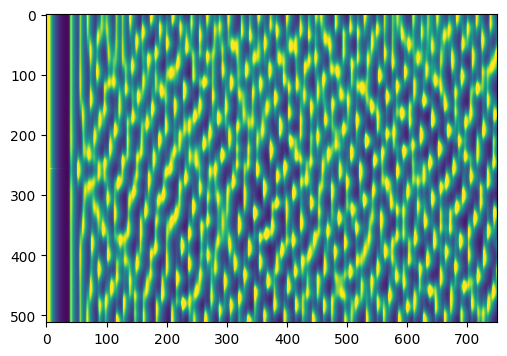

In [275]:
fig = plt.figure(figsize=(16,4))
_ = plt.imshow(res.u.T, vmin=0, vmax=1)

In [ ]:
_ = plt.plot(res.t, res.u[:, 300])